# Predicting extreme wind speeds in Denmark

The goal of this notebook is to predict extreme wind speeds in Denmark using data from 1.1.1995 to 31.12.2017 (data from www.tutiempo.net). Increasing extreme weather events in combination with ramping up the wind power production may obviously lead to changes in the wind speeds.

In order to investigate the influences of those recent events and identifying trends, data from five different weather stations all over Denmark is compared. The data will be modelled in a Bayesian framework aiming at providing information on the probability of storm occurrences in years to come.

The initial part of this notebook details the generalized pareto model used for fitting the tail of the extreme wind speed distribution. The five different datasets enables the consideration of three different models, the pooled, separate and hierarchical. A selection between these three models is made by considering the predictive performance of each model using leave one out cross validation (psis-loo) and test statistic analysis. The best performing model is then used to make predictions of a major storm in the coming 23 years.    

Finally, the time resolved data will be used to determine whether the Danish climate is becoming more extreme by comparing the pareto parameters obtained from consecutive 5 year periods.   

# Model description

The likelihood of the extreme wind speeds will be modeled using a generalized pareto distribution that is used for extreme value analysis. Therefore, a cut-off wind speed is needed at which the data will be trimmed. The generalized pareto distribution has three parameters, the location parameter $ \mu $, the scale parameter $\sigma$ and the shape parameter $\xi$. The probability density function is given as

$$
f_{\xi,\mu,\sigma}(x) = \frac{1}{\sigma} \left( 1 + \frac{\xi(x-\mu)}{\sigma} \right)^{\left( -\frac{1}{\xi} - 1 \right)}
$$
<br>

where the validity is given for x $ \geq \mu$ when $\xi  \geq$ 0 and $\mu \leq x \leq \mu - \sigma/\xi$ when $\xi < 0$. In order to find appropriate tail cut off values, Q-Q plots were used to identify possible candidates. This has to ensure a homogeneous behavior of the tail as well as there are enough data points left in the tail.

# Setting up the python environment

For the following data visualizations, in a first step the python environment is prepared.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
from scipy.interpolate import UnivariateSpline

import pystan
from psis import psisloo,sumlogs
import stan_utility

/home/felix/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# default plot settings
plt.rc('font', size = 12)

# Visualize the data

In [3]:
# load data 
city_name_end = ['cop','aar','aal','ode','esb']
for i,my_city in enumerate(city_name_end):
    init_data = np.load('winddata'+my_city+'.npy')
    ii = np.where(init_data != '-1')
    init_data = init_data[ii]
    init_data = np.array(init_data, dtype= 'float64')
    if i == 0:
        wind_data = np.sort(init_data)
    else:
        wind_data = np.append(wind_data,np.sort(init_data))

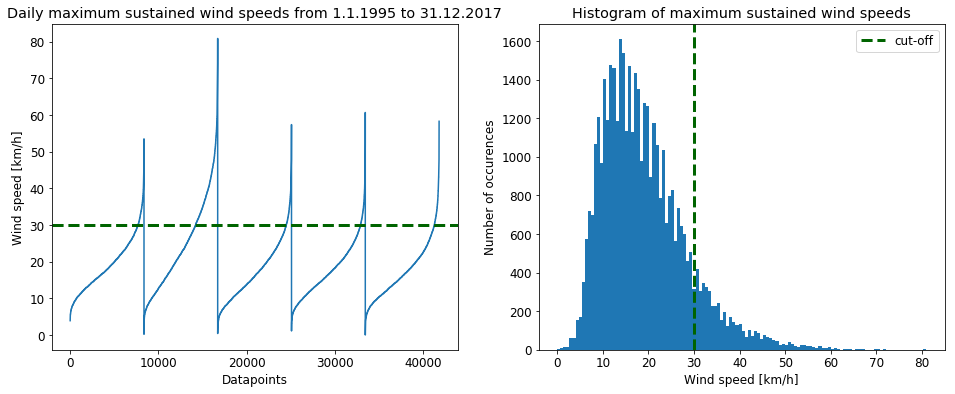

In [4]:
fig, axes = plt.subplots(ncols = 2, figsize = (16,6))

ax = axes[0]
ax.plot(wind_data)
ax.set_title('Daily maximum sustained wind speeds from 1.1.1995 to 31.12.2017')
ax.set_xlabel('Datapoints'); ax.set_ylabel('Wind speed [km/h]')
ax.axhline(y= 30, color = 'darkgreen', linestyle = 'dashed', lw = 3)

ax = axes[1]
ax.hist(wind_data.astype(np.float),bins='auto')
ax.set_title('Histogram of maximum sustained wind speeds')
ax.axvline(x= 30, color = 'darkgreen', linestyle = 'dashed', lw = 3, label = 'cut-off')
ax.set_xlabel('Wind speed [km/h]'); ax.set_ylabel('Number of occurences'); ax.legend()

The daily maximum wind speed was obtained by sorting the data and therefore has five distinct peaks coinciding with the five investigated cities. This ordering is important in our case, since it is used in the stan models later to separate the data. Most of the cities look similar, except for Aarhus that has larger wind speed values than the other cities (compare to second peak in the left graph). In the graph to the right, the cut-off value is indicated for all the data showing where the values where trimmed priror to the extreme values analysis.

# Choice for cut-off value

/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0.5,1,'QQ-plot for Normal distribution for all data')

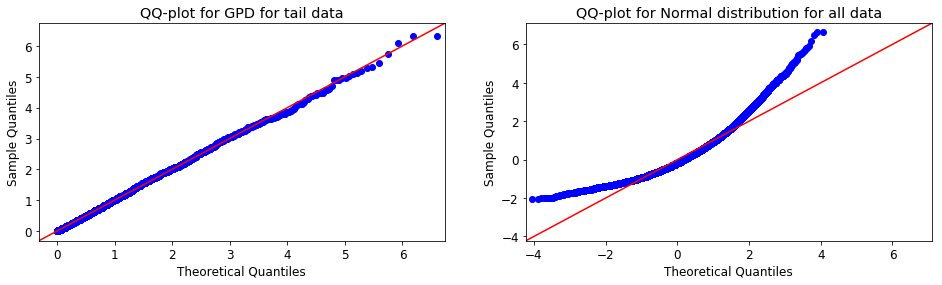

In [5]:
# now test the cut-off
tail_cutoff = 30
tail_bool = wind_data > tail_cutoff
tail_data = wind_data[tail_bool]

# visualize fit to GPD distribution
fig, axes = plt.subplots(nrows = 1,ncols = 2, figsize = (16,4))

qqp = sm.ProbPlot(tail_data - 30, stats.genpareto , fit= True)
qqp.qqplot(line='45',ax = axes[0])
axes[0].set_title('QQ-plot for GPD for tail data')

qqp = sm.ProbPlot(wind_data, stats.norm , fit= True)
qqp.qqplot(line='45',ax = axes[1])
axes[1].set_title('QQ-plot for Normal distribution for all data')


The Q-Q plot suggests that the GPD distribution can describe the tail data well as the points follow the red line when using a wind speed cut-off value of 30 km/h. This is also compared to assuming a normal distribution where the sample quantiles clearly deviate from the theoretical quantiles expected when using a normal distribution.

# Prior choices

In order to understand which priors might be useful, the different parameters and their influence on the shape of the GPD are shown.

In [6]:
def gpareto_pdf(x, u, sigma, k):
    # generalized pareto for point y, cutoff u, scale sigma and shape k
    if abs(k) < 10**(-15):
        return (1/sigma)*np.exp((-(x-u))/sigma)
    else:
        # take the support into account
        y = np.zeros([len(x)])
        if k < 0:
            x_sup = x[x <= tail_cutoff-sigma/k]
        else:
            x_sup = x[x >= tail_cutoff]
        y[0:len(x_sup)] = (1/sigma)*np.power((1+k*(x_sup-u)/sigma),(-1/k-1)) 
        return y

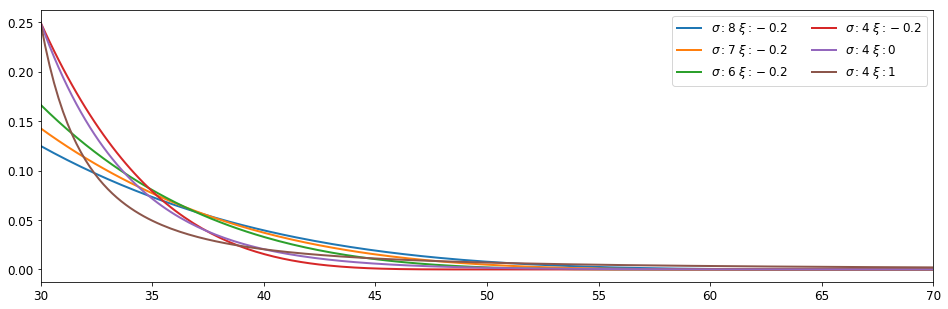

In [7]:
sigma_test = [8,7,6,4,4,4]
k_test = [-0.2,-0.2,-0.2,-0.2,0,1]
fig = plt.figure(figsize = (16,5))
x = np.linspace(tail_cutoff,70,200)
for i,k in enumerate(k_test):
    y = gpareto_pdf(x,tail_cutoff, sigma_test[i], k)
    plt.plot((x),(y),linewidth = 2, label = r'$\sigma: {1} \; \xi: {0}$'.format(k,sigma_test[i]))
plt.xlim([tail_cutoff,70])
plt.legend(ncol  = 2)

Using a prior on either $\sigma$ or $\xi$ seems very sensitive given the plot above. We had little prior knowledge of the data and so for the separate and pooled model we decided to use a non-informative prior for the parameters (uniform prior). This can be justified since we have a large number of datapoints which means that the influence of any reasonable prior choice will have negligible effect. 
For the hierarchical we use a normal distribution as hyperprior for both parameters fitted for. The distribution of these hyperprior is such that it has a fairly large variance to make it somewhat weakly informative. In more detail, for the hierarchichal model the $\xi$ and $\sigma$ values followed the two hyperparameters $\mu_0$ and $\mu_1$ (respectively) defined as normal distributions according to
$$
\mu_0 \sim \mathcal{N}(-0.1,10)
$$

$$
\mu_1 \sim  \mathcal{N}(5,10)
$$
<br>


# Data preparation
The same input data can be used for the hierarchichal and the separate model. The pooled model needs different input data.

In [8]:
# Prepare data for stan model for the hierarchichal and the separate model
peaks = np.where(np.diff(tail_data)<0)[0] #All peaks except the last one.
dstart = np.append([1],peaks+2) # indexing cities
dend   = np.append(peaks+1,[len(tail_data)]) # indexing cities

ymin = tail_data[dstart-1]
ymax = tail_data[dend-1]
N = len(tail_data)
cti = len(city_name_end) # number of cities to include
ctsf = 0 #city start from (0.,4)

data = dict(
    N = dend[ctsf+cti-1]-dstart[ctsf]+1,#,N,
    y = tail_data[dstart[ctsf]-1:dend[ctsf+cti-1]],   # observations
    K = cti,
    ymin = np.array([ymin[ctsf:ctsf+cti]])[0,:],
    ymax = np.array([ymax[ctsf:ctsf+cti]])[0,:],
    dstart = np.array([dstart[ctsf:ctsf+cti]]-dstart[ctsf]+1)[0,:],
    dend = np.array([dend[ctsf:ctsf+cti]]-dstart[ctsf]+1)[0,:],
)

In [9]:
# Prepare data for the pooled stan model
dstart_pool = [0] # indexing cities, only one needed since it's the pooled model
dend_pool   = [len(tail_data)] # indexing cities

ymin_pool = [min(tail_data)]
ymax_pool = [max(tail_data)]
N = len(tail_data)
cti_pool = 1 # pooled
ctsf_pool = 0 #city start from

data_pooled = dict(
    N = N,#,N,
    y = tail_data,   # observations
    K = cti_pool,
    ymin = ymin_pool,
    ymax = ymax_pool,
    dstart = dstart_pool,
    dend = [N],
)

# Stan code for the three different models
Start with the separate model

In [10]:
with open('wind_sep.stan') as file:
    print(file.read())

//separate model for GPD
functions {
  real gpareto_lpdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log pdf 
    int N = rows(y);
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return -(1+inv_k)*sum(log1p((y-ymin) * (k/sigma))) -N*log(sigma);
    else
      return -sum(y-ymin)/sigma -N*log(sigma); // limit k->0
  }
  real gpareto_rng(real ymin, real k, real sigma) {
    // generalised Pareto rng
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return ymin + (uniform_rng(0,1)^-k -1) * sigma / k;
    else
      return ymin - sigma*log(uniform_rng(0,1)); // limit k->0
   }
  real gpareto_lccdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log ccdf
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma

In [11]:
model_sep = stan_utility.compile_model('wind_sep.stan')

Using cached StanModel


Now the hierarchichal model

In [12]:
with open('wind_hier.stan') as file:
    print(file.read())

//Hierarchical model for the generalized pareto distribution
functions {
  real gpareto_lpdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log pdf 
    int N = rows(y);
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return -(1+inv_k)*sum(log1p((y-ymin) * (k/sigma))) -N*log(sigma);
    else
      return -sum(y-ymin)/sigma -N*log(sigma); // limit k->0
  }
  real gpareto_lccdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log ccdf
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return (-inv_k)*sum(log1p((y-ymin) * (k/sigma)));
    else
      return -sum(y-ymin)/si

In [13]:
model_hier = stan_utility.compile_model('wind_hier.stan')

Using cached StanModel


Last input is the stan code for the pooled model.

In [14]:
with open('pooledpareto.stan') as file:
    print(file.read())

//pooled model for GPD
functions {
  real gpareto_lpdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log pdf 
    int N = rows(y);
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return -(1+inv_k)*sum(log1p((y-ymin) * (k/sigma))) -N*log(sigma);
    else
      return -sum(y-ymin)/sigma -N*log(sigma); // limit k->0
  }
  real gpareto_rng(real ymin, real k, real sigma) {
    // generalised Pareto rng
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return ymin + (uniform_rng(0,1)^-k -1) * sigma / k;
    else
      return ymin - sigma*log(uniform_rng(0,1)); // limit k->0
   }
  real gpareto_lccdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log ccdf
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma >

In [15]:
model_pool = stan_utility.compile_model('pooledpareto.stan')

Using cached StanModel


# Model evaluation using posterior predicitve checking

An important part of this work is to be able to predict whether there will be extreme winds/storms in the future. For this we draw samples based on the posterior distibrution (using STAN). With this we can construct a predictive distribution of future extreme wind speeds.
In more detail what we do is we make n new distributions of the windspeeds, where n is the number of data points. We then draw the maximum speed of each distribution and compare them with maximum of the data  (see plots named Max wind speed for _CITY_). Ideally, the peak of the histogram should coincide with the maximum of the real data, however as we can see most outcomes show a somewhat undershooting of the maximum values. This then means that it is has a harder time predicting the extreme values that have actually been measured (see plots named Probabilities for _CITY_). Only Aalborg appears to be able to predict the same extreme values. This can also be inferred from the values for the probablilty of a storm greater than 70km/h (written just above the mentioned plots). The models will be evaluated in the following order: pooled, separate, hierarchichal.

In [16]:
fit_pool = model_pool.sampling(data=data_pooled, seed = 1231)
samples_pool = fit_pool.extract(permuted = True)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


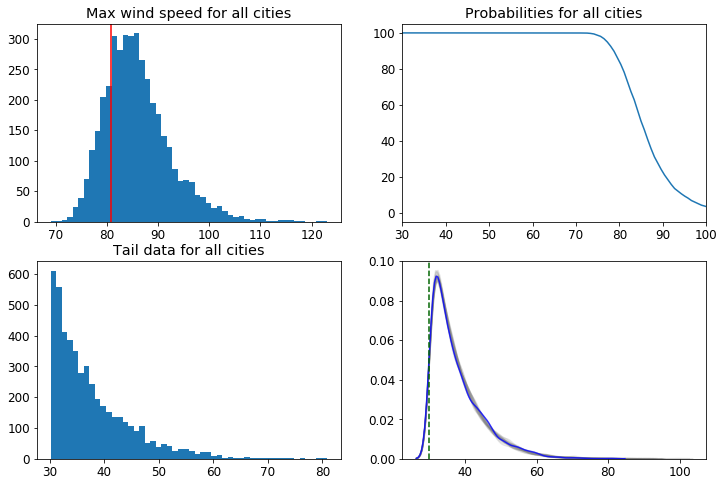

In [17]:
yrep_pool = samples_pool['yrep']
my_city = 'all cities'
# also visualize some
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))

ax = axes[0,0]
ax.hist(np.max(yrep_pool[:,dstart_pool[0]:dend_pool[0]],axis = 1), bins = 50)
ax.axvline(x = max(tail_data[dstart_pool[0]:dend_pool[0]]), color = 'red', label = 'max y')
ax.set_title('Max wind speed for {0}'.format(my_city))

ax = axes[0,1]
xnew = np.linspace(tail_cutoff,184,200)
ynew = list()
for xn in xnew:
    ynew.append(100*len([p for p in np.max(yrep_pool[:,dstart_pool[0]:dend_pool[0]],axis = 1) if p > xn])/len(yrep_pool[:,dstart[0]:dend[0]]))
ax.plot(xnew,ynew)
ax.set_xlim([30,100])
ax.set_title('Probabilities for {0}'.format(my_city))

ax = axes[1,0]
ax.hist(tail_data[dstart_pool[0]:dend_pool[0]], bins = 50)
ax.set_title('Tail data for {0}'.format(my_city))

ax = axes[1,1]
for draw in range(0,20):
    sigma_draws = samples_pool['sigma'][draw:draw+1]
    k_draws = samples_pool['k'][draw:draw+1]
    sns.kdeplot(samples_pool['yrep'][:,dstart_pool[0] + draw], alpha = 0.2, color="gray")
sigma_mean = np.mean(samples_pool['sigma'])
k_mean = np.mean(samples_pool['k'])
sns.kdeplot(tail_data[dstart_pool[0]:dend_pool[0]], alpha = 0.8, color="blue")
ax.axvline(x = (tail_cutoff), color = 'darkgreen',linestyle = 'dashed', label = 'cutoff')
plt.show()

The predicted maximum wind speed for all cities drawn from the posterior, compared to the actual maximum value (red horizontal line in top left graph), coincides quite well but appears to be overestimated.

Now the separate model

In [18]:
fit_sep = model_sep.sampling(data=data, seed = 192863)
samples_sep = fit_sep.extract(permuted = True)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


-------cop------------
Sigma: 5.18
K-value: -0.16
Chance storm > 74km/h: 0.025 %


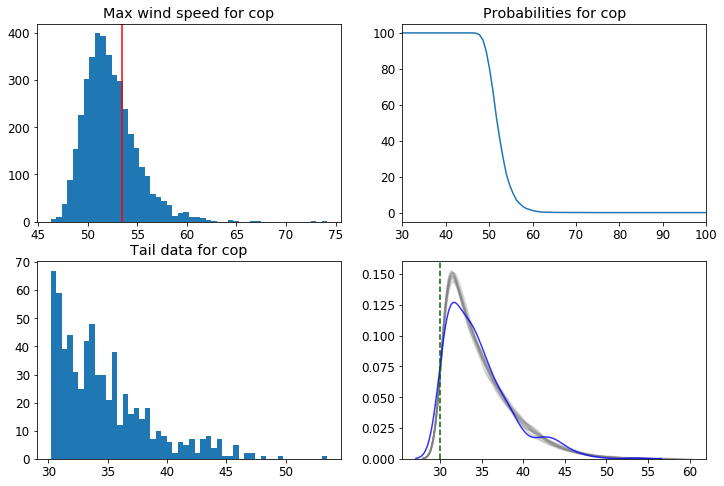

-------aar------------
Sigma: 12.19
K-value: -0.21
Chance storm > 74km/h: 95.475 %


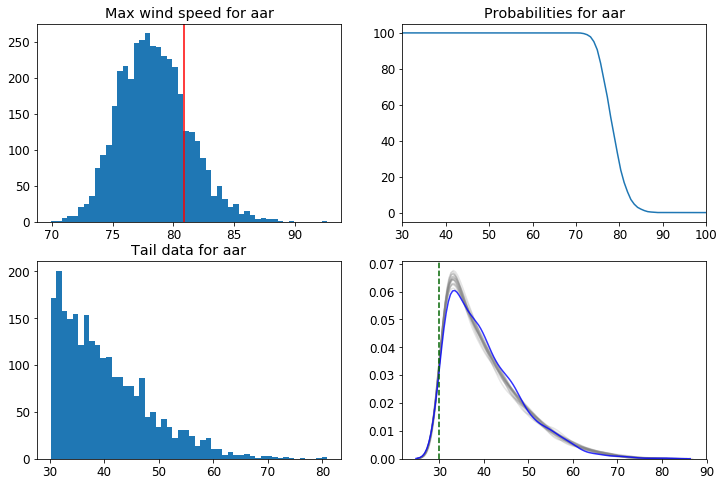

-------aal------------
Sigma: 5.17
K-value: -0.04
Chance storm > 74km/h: 4.6 %


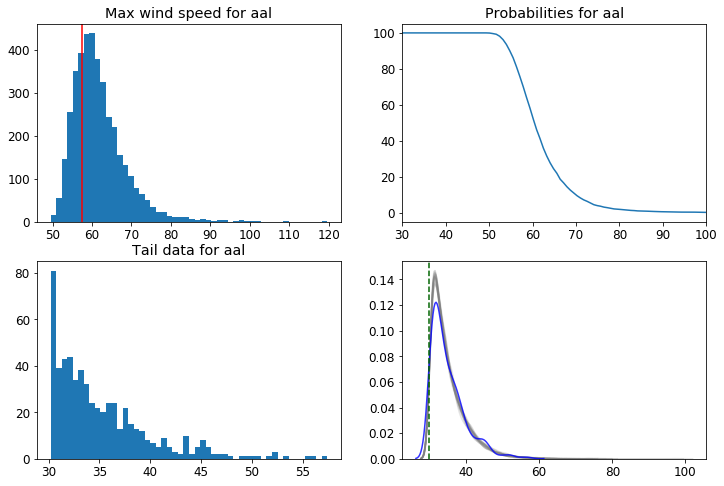

-------ode------------
Sigma: 5.10
K-value: -0.05
Chance storm > 74km/h: 2.95 %


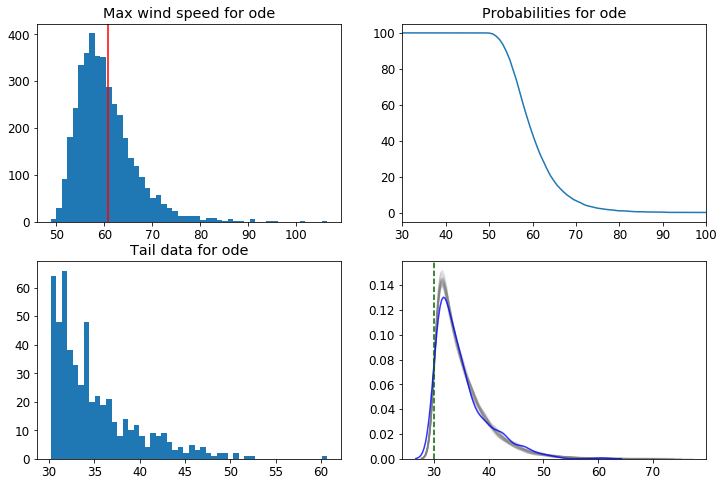

-------esb------------
Sigma: 5.76
K-value: -0.10
Chance storm > 74km/h: 1.4 %


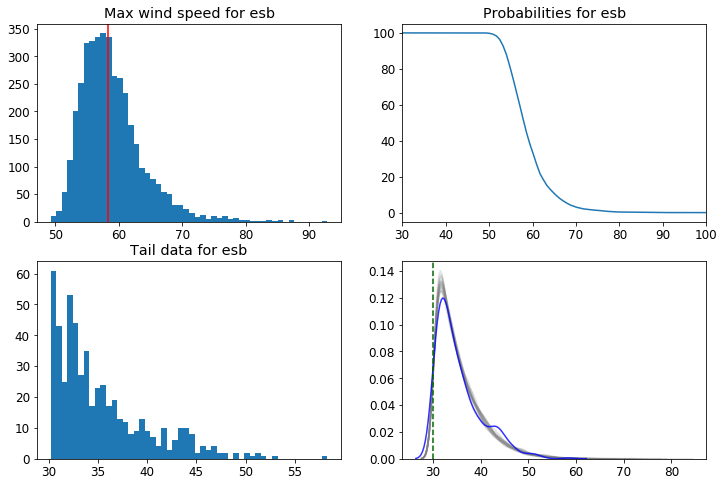

In [19]:
# show some results
yrep_sep = samples_sep['yrep']
for i,my_city in enumerate(city_name_end):
    print('-------{0}------------'.format(my_city))
    print('Sigma: {:.2f}'.format(np.mean(samples_sep['sigma'][:,i])))
    print('K-value: {:.2f}'.format(np.mean(samples_sep['k'][:,i])))
    print('Chance storm > 74km/h: {0} %'.format(100*len([i for i in np.max(yrep_sep[:,dstart[i]:dend[i]],axis = 1) if i > 74])/len(yrep_sep[:,dstart[i]:dend[i]])))
    
    # also visualize some
    fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))
    ax = axes[0,0]
    ax.hist(np.max(yrep_sep[:,dstart[i]:dend[i]],axis = 1), bins = 50)
    ax.axvline(x = max(tail_data[dstart[i]:dend[i]]), color = 'red', label = 'max y')
    ax.set_title('Max wind speed for {0}'.format(my_city))
    
    ax = axes[0,1]
    xnew = np.linspace(tail_cutoff,184,200)
    ynew = list()
    for xn in xnew:
        ynew.append(100*len([p for p in np.max(yrep_sep[:,dstart[i]:dend[i]],axis = 1) if p > xn])/len(yrep_sep[:,dstart[i]:dend[i]]))
    ax.plot(xnew,ynew)
    ax.set_xlim([30,100])
    ax.set_title('Probabilities for {0}'.format(my_city))
    
    ax = axes[1,0]
    ax.hist(tail_data[dstart[i]:dend[i]], bins = 50)
    ax.set_title('Tail data for {0}'.format(my_city))
    
    ax = axes[1,1]
    for draw in range(0,20):
        sigma_draws = samples_sep['sigma'][draw:draw+1,i]
        k_draws = samples_sep['k'][draw:draw+1,i]
        sns.kdeplot(samples_sep['yrep'][:,dstart[i] + draw], alpha = 0.2, color="gray")
    sigma_mean = np.mean(samples_sep['sigma'][:,i])
    k_mean = np.mean(samples_sep['k'][:,i])
    sns.kdeplot(tail_data[dstart[i]:dend[i]], alpha = 0.8, color="blue")
    ax.axvline(x = (tail_cutoff), color = 'darkgreen',linestyle = 'dashed', label = 'cutoff')
    plt.show()

The predicted maximum wind speeds coincide quite well with the actual wind speed in each of the five different cities. This indicates, that the GPD seems to fit the tail data well.

Finally posterior predictive checking for the hierarchichal model

In [20]:
fit_hier = model_hier.sampling(data=data, seed = 12863)
samples_hier = fit_hier.extract(permuted = True)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


-------cop------------
Sigma: 5.16
K-value: -0.15
Chance storm > 74km/h: 0.0 %


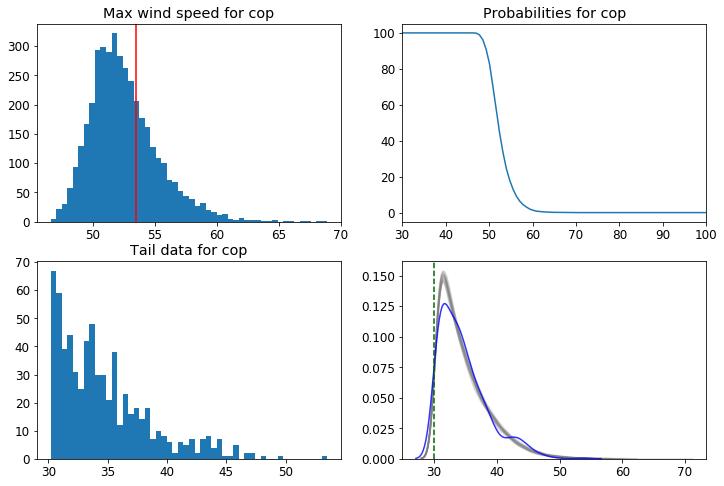

-------aar------------
Sigma: 12.10
K-value: -0.20
Chance storm > 74km/h: 95.575 %


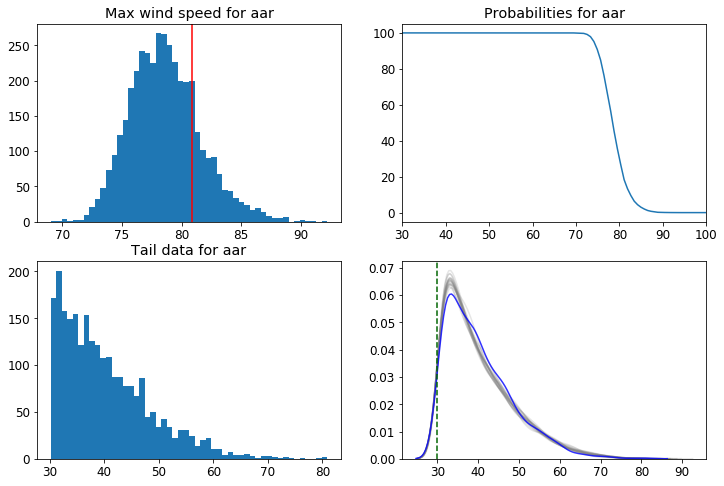

-------aal------------
Sigma: 5.28
K-value: -0.06
Chance storm > 74km/h: 2.275 %


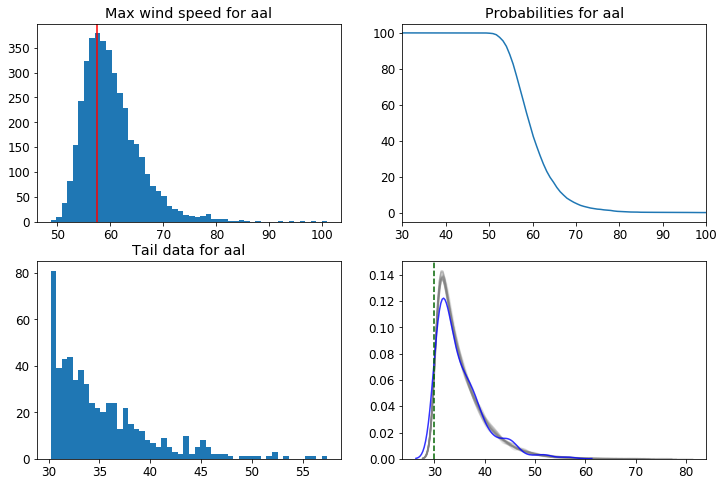

-------ode------------
Sigma: 5.20
K-value: -0.07
Chance storm > 74km/h: 1.6 %


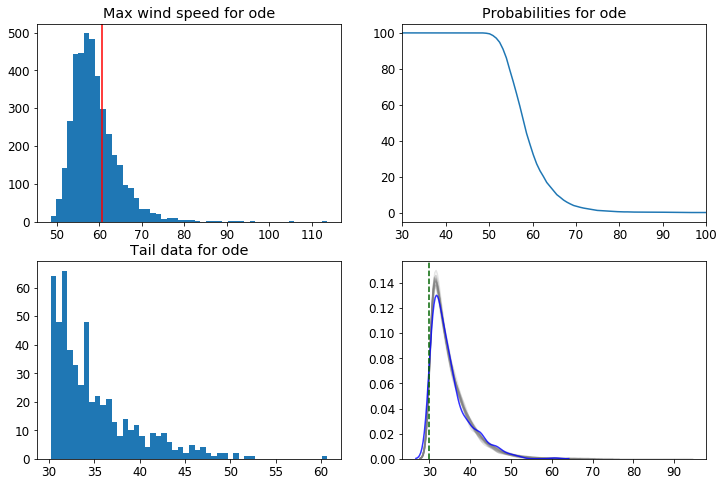

-------esb------------
Sigma: 5.80
K-value: -0.11
Chance storm > 74km/h: 0.6 %


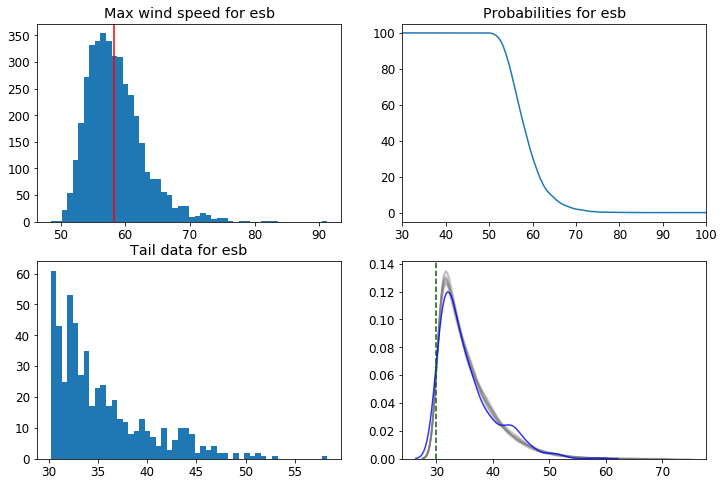

In [21]:
# show some results
yrep_hier = samples_hier['yrep']
for i,my_city in enumerate(city_name_end):
    print('-------{0}------------'.format(my_city))
    print('Sigma: {:.2f}'.format(np.mean(samples_hier['sigma'][:,i])))
    print('K-value: {:.2f}'.format(np.mean(samples_hier['k'][:,i])))
    print('Chance storm > 74km/h: {0} %'.format(100*len([i for i in np.max(yrep_hier[:,dstart[i]:dend[i]],axis = 1) if i > 74])/len(yrep_hier[:,dstart[i]:dend[i]])))
    
    # also visualize some
    fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))
    ax = axes[0,0]
    ax.hist(np.max(yrep_hier[:,dstart[i]:dend[i]],axis = 1), bins = 50)
    ax.axvline(x = max(tail_data[dstart[i]:dend[i]]), color = 'red', label = 'max y')
    ax.set_title('Max wind speed for {0}'.format(my_city))
    
    ax = axes[0,1]
    xnew = np.linspace(tail_cutoff,184,200)
    ynew = list()
    for xn in xnew:
        ynew.append(100*len([p for p in np.max(yrep_hier[:,dstart[i]:dend[i]],axis = 1) if p > xn])/len(yrep_hier[:,dstart[i]:dend[i]]))
    ax.plot(xnew,ynew)
    ax.set_xlim([30,100])
    ax.set_title('Probabilities for {0}'.format(my_city))
    
    ax = axes[1,0]
    ax.hist(tail_data[dstart[i]:dend[i]], bins = 50)
    ax.set_title('Tail data for {0}'.format(my_city))
    
    ax = axes[1,1]
    for draw in range(0,20):
        sigma_draws = samples_hier['sigma'][draw:draw+1,i]
        k_draws = samples_hier['k'][draw:draw+1,i]
        sns.kdeplot(samples_hier['yrep'][:,dstart[i] + draw], alpha = 0.2, color="gray")
    sigma_mean = np.mean(samples_hier['sigma'][:,i])
    k_mean = np.mean(samples_hier['k'][:,i])
    sns.kdeplot(tail_data[dstart[i]:dend[i]], alpha = 0.8, color="blue")
    ax.axvline(x = (tail_cutoff), color = 'darkgreen',linestyle = 'dashed', label = 'cutoff')
    plt.show()

The hierarchichal model performs quite similar compared to the separate model.

# Convergence and PSIS-LOO analysis for the three models
In order to estimate the validty of the STAN-outputtet results we check if the samplingroutines have converged. For all samples the Rhat values are below 1.1 and so we can conclude that the chain converged. Furthermore, the number of effective samples is of order of magnitude 3 (~$10^3$). This along with the Rhat values show that we have good samples. Since we have ~4000 datapoints it is hard to include them all in this document. It doesn’t make sense to include the outputtet fit as it is too long and is therefore not shown here. So here we hope you believe us when we say that all values are what we wrote. 
In order to compare the three models with each other we perform the PSIS-LOO analysis. In order to be able to do this we check to see if the k-values are below 0.7. For the separate, hierarchichal and pooled model there are no values of khat > 0.7 and so the models can be compared with the PSIS-LOO values which show the hierarchical to be minutely better (summary of results can be found in a table at the end of this section).

P-eff: 1.9795968646285473
LOO-pool -14597.055792790721


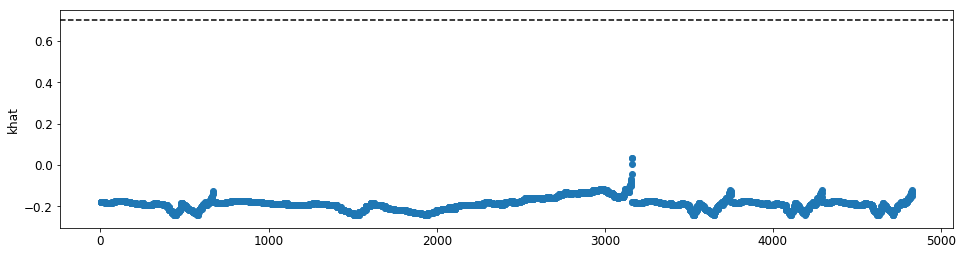

In [22]:
log_like = samples_pool['log_lik']
loo_pool, loos, ks_pool = psisloo(log_like)
lppd_pool = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
peff_pool = lppd_pool - loo_pool
fig = plt.figure(figsize = (16,4))
plt.scatter(np.arange(1, len(ks_pool) + 1),ks_pool)
plt.axhline(y=0.7, linestyle = '--', color = 'k')
plt.ylabel('khat')
print('P-eff:',peff_pool)
print('LOO-pool',loo_pool)

PSIS - LOO analysis for the separate model


P-eff: 9.784458659998563
LOO-sep -14218.982527683951


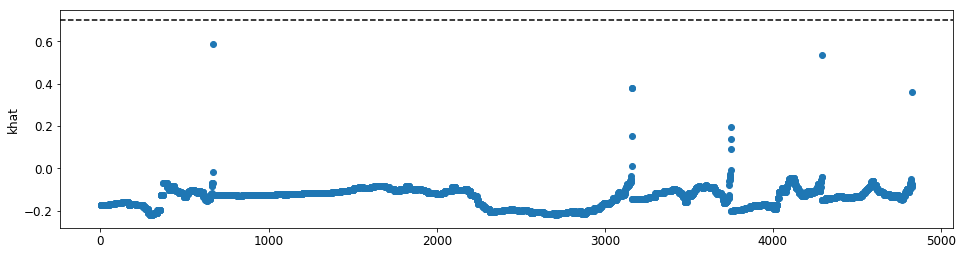

In [23]:
log_like = samples_sep['log_lik']
loo_sep, loos, ks_sep = psisloo(log_like)
lppd_sep = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
peff_sep = lppd_sep - loo_sep
fig = plt.figure(figsize = (16,4))
plt.scatter(np.arange(1, len(ks_sep) + 1),ks_sep)
plt.axhline(y=0.7, linestyle = '--', color = 'k')
plt.ylabel('khat')
print('P-eff:',peff_sep)
print('LOO-sep',loo_sep)

PSIS LOO for hierarchichal

P-eff: 9.437552718463849
LOO-sep -14218.743883962801


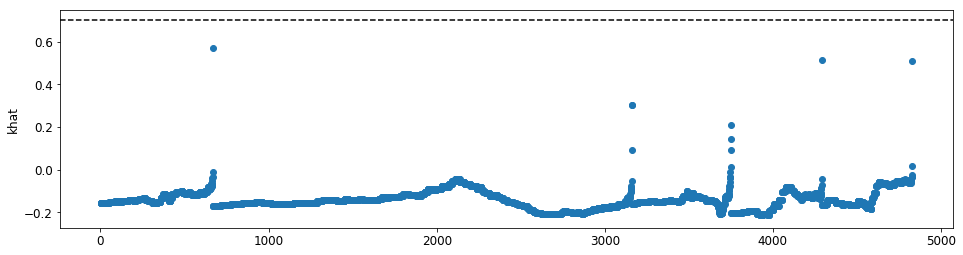

In [24]:
log_like = samples_hier['log_lik']
loo_hier, loos, ks_hier = psisloo(log_like)
lppd_hier = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
peff_hier = lppd_hier - loo_hier
fig = plt.figure(figsize = (16,4))
plt.scatter(np.arange(1, len(ks_hier) + 1),ks_hier)
plt.axhline(y=0.7, linestyle = '--', color = 'k')
plt.ylabel('khat')
print('P-eff:',peff_hier)
print('LOO-sep',loo_hier)

In [25]:
import pandas as pd
pd.DataFrame(np.array([[loo_pool,loo_sep,loo_hier],[peff_pool,peff_sep,peff_hier]]).T, index = ['Pooled','Separate','Hierarchichal'], columns = ['PSIS-LOO','P-effective'])

,PSIS-LOO,P-effective
Pooled,-14597.055793,1.979597
Separate,-14218.982528,9.784459
Hierarchichal,-14218.743884,9.437553


# Cutoff dependence 

An important part of the model is the cutoff selection. We selected this based on the QQ plot, but there is still some bias in the specific choice. We test the dependence on this choice by performing the analysis using 25, 30, 35 km/h as cutoffs. 

The below plots demonstrate the evolution of the weighted loo discrepancy between the separate and hierarchical model, the number of effective parameters, and the probablity of a storm in esbjerg. 


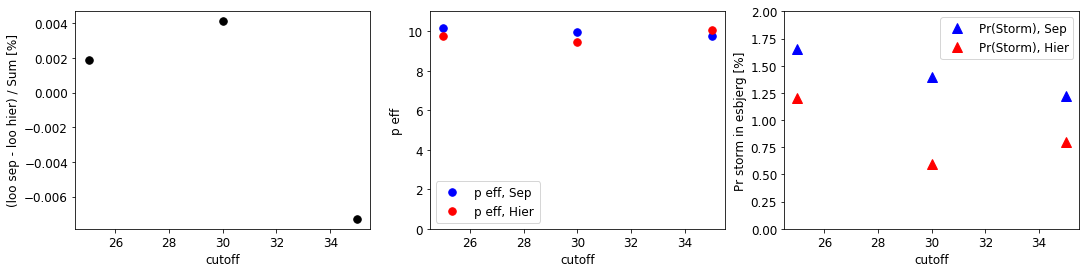

In [26]:
cutoff_list = [25,30,35]

peff_sep_list = [10.15,9.98,9.76]
loo_sep_list = [-26931,-14219.17,-7541]
pStorm_sep_list = [1.65,1.4,1.225]

peff_hier_list = [9.74,9.44,10.08]
loo_hier_list = [-26930,-14218,-7542.1]
pStorm_hier_list = [1.2,0.6,0.8]

figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 3.0  # width
figsize[1] *= 1  # height

fig, axes = plt.subplots(1,3, figsize=figsize)
ax = axes[0]

ax.plot(cutoff_list,100*(np.array(loo_sep_list)-np.array(loo_hier_list))/(np.array(loo_sep_list)+np.array(loo_hier_list)),'k.', label = r'Sep', MarkerSize = 15)
ax.set_title('')
ax.set_xlabel(r'cutoff')
ax.set_ylabel(r'(loo sep - loo hier) / Sum [%]')

ax = axes[1]
ax.plot(cutoff_list,np.array(peff_sep_list),'b.', label = r'p eff, Sep ', MarkerSize = 15)
ax.plot(cutoff_list,peff_hier_list, 'r.',label = r'p eff, Hier', MarkerSize = 15)

ax.set_title('')
ax.set_xlabel(r'cutoff')
ax.set_ylabel(r'p eff')
ax.set_ylim([0,11])
ax.legend()

ax = axes[2]
ax.plot(cutoff_list,pStorm_sep_list,'b^', label = r'Pr(Storm), Sep', MarkerSize = 10)
ax.plot(cutoff_list,pStorm_hier_list, 'r^',label = r'Pr(Storm), Hier', MarkerSize = 10)

ax.set_title('')
ax.set_xlabel(r'cutoff')
ax.set_ylabel(r'Pr storm in esbjerg [%]')
ax.set_ylim([0,2])
ax.legend()


The evolution of the loo difference and number of effective parameters demonstrates that these models are quite close in predictive performance, the model to choose depends on the cutoff. The results of the analysis (the probability of storm) is however quite stable with respect to the cutoff so we conclude that our analysis is stable with regard to the cutoff selection which is important when choosing the generalized pareto distribution.

# Cut data in time intervals and use model to predict $\xi$ and $\sigma$ over time
In the following part the data is evenly split into five year time intervalls. This allows to extract the shape parameters for each of the cities separately and see a potential trend in the change of these parameters over time. Solely the hierarchichal model is used for this analysis. The goal is to see if the change in the shape parameters indicates a change in extreme wind speeds over the last 20 years (e.g. more extreme weather due to climate change).

In [27]:
n_splits = 5 # 20/n_splits = time intervals
sigmas = np.zeros((n_splits, len(city_name_end)))
ks = np.zeros((n_splits,len(city_name_end)))
k_25 = [[] for i in range(n_splits)]; k_97 = [[] for i in range(n_splits)]
sig_25 = [[] for i in range(n_splits)]; sig_97 = [[] for i in range(n_splits)]
for n_split in range(n_splits):
    # load data 
    for i,my_city in enumerate(city_name_end):
        init_data = np.load('winddata'+my_city+'.npy')
        n_cut = int(len(init_data)/n_splits)
        init_data = init_data[n_split*n_cut:(n_split + 1)*n_cut]
        ii = np.where(init_data != '-1')
        init_data = init_data[ii]
        init_data = np.array(init_data, dtype= 'float64')
        if i == 0:
            wind_data_cut = np.sort(init_data)
        else:
            wind_data_cut = np.append(wind_data_cut,np.sort(init_data))
    # hierarchichal model
    tail_bool_cut = wind_data_cut > tail_cutoff
    tail_data_cut = wind_data_cut[tail_bool_cut]
    # Prepare data for stan model
    peaks = np.where(np.diff(tail_data_cut)<0)[0] #All peaks except the last one.
    dstart_cut = np.append([1],peaks+2) # indexing cities
    dend_cut   = np.append(peaks+1,[len(tail_data_cut)]) # indexing cities

    ymin = tail_data_cut[dstart_cut-1]
    ymax = tail_data_cut[dend_cut-1]
    N = len(tail_data_cut)
    cti = len(city_name_end) # number of cities to include
    ctsf = 0 #city start from (0.,4)

    data = dict(
        N = dend_cut[ctsf+cti-1]-dstart_cut[ctsf]+1,#,N,
        y = tail_data_cut[dstart_cut[ctsf]-1:dend_cut[ctsf+cti-1]],   # observations
        K = cti,
        ymin = np.array([ymin[ctsf:ctsf+cti]])[0,:],
        ymax = np.array([ymax[ctsf:ctsf+cti]])[0,:],
        dstart = np.array([dstart_cut[ctsf:ctsf+cti]]-dstart_cut[ctsf]+1)[0,:],
        dend = np.array([dend_cut[ctsf:ctsf+cti]]-dstart_cut[ctsf]+1)[0,:],
    )
    
    #now use hierarchichal model
    fit_hier = model_hier.sampling(data=data, seed = 12863)
    samples_hier = fit_hier.extract(permuted = True)
    k_25[n_split].append(np.percentile(samples_hier['k'],2.5,axis=0))
    k_97[n_split].append(np.percentile(samples_hier['k'],97.5,axis=0))
    sig_25[n_split].append(np.percentile(samples_hier['sigma'],2.5,axis=0))
    sig_97[n_split].append(np.percentile(samples_hier['sigma'],97.5,axis=0))
    sigmas[n_split,:] = np.mean(samples_hier['sigma'],axis=0)
    ks[n_split,:] = np.mean(samples_hier['k'],axis=0)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Text(0,0.5,'$\\sigma$')

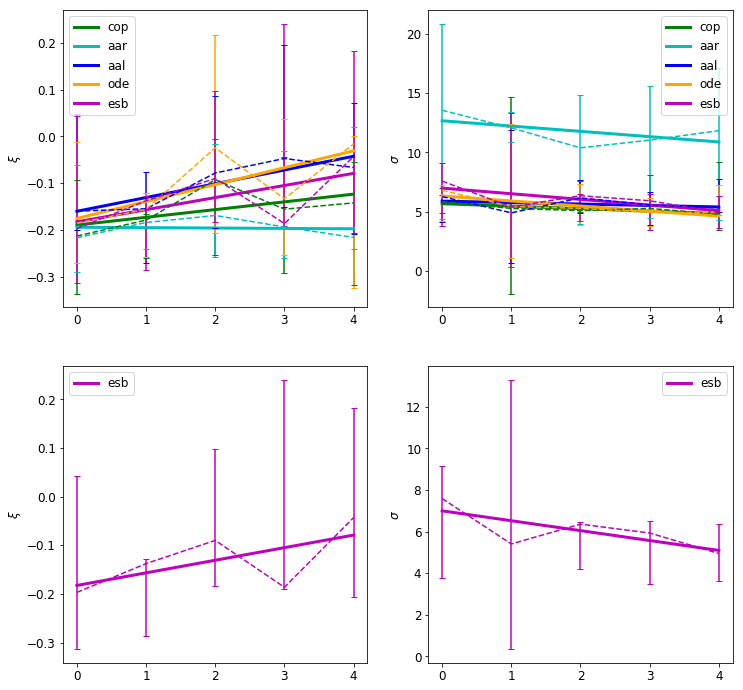

In [28]:
# plot sigma and ks over years
colors = ['g','c','b','orange','m']
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12,12))
ax = axes[0,0]
for i,my_city in enumerate(city_name_end):
    ax.errorbar(np.arange(len(ks[:,i])),ks[:,i], ls = '--',
                yerr = [abs(k_25[i][0] - ks[:,i]),abs(k_97[i][0] - ks[:,i])],
                capsize = 3,
                color = colors[i])
    ax.set_xticks(np.arange(n_splits))
    x = np.arange(n_splits)
    spl = UnivariateSpline(x, ks[:,i], k =1)
    xs = np.linspace(0, n_splits - 1, 100)
    ax.plot(xs, spl(xs), lw=3, label = city_name_end[i],color = colors[i])
ax.legend(loc = 'best')
ax.set_ylabel(r'$\xi$')

ax = axes[0,1]
for i,my_city in enumerate(city_name_end):
    ax.errorbar(np.arange(len(sigmas[:,i])),sigmas[:,i], ls = '--',
                yerr = [abs(sig_25[i][0] - sigmas[:,i]),abs(sig_97[i][0] - sigmas[:,i])],
                capsize = 3,
                color = colors[i])
    ax.set_xticks(np.arange(n_splits))
    spl = UnivariateSpline(x, sigmas[:,i],k = 1)
    xs = np.linspace(0, n_splits - 1, 100)
    ax.plot(xs, spl(xs), lw=3,label = city_name_end[i],color = colors[i])
ax.legend(loc = 'best')
ax.set_ylabel(r'$\sigma$')
# show Esbjerg as a sample city separately
ax = axes[1,0]
for i in [-1]:
    ax.errorbar(np.arange(len(ks[:,i])),ks[:,i], ls = '--',
                yerr = [abs(k_25[i][0] - ks[:,i]),abs(k_97[i][0] - ks[:,i])],
                capsize = 3,
                color = colors[i])
    ax.set_xticks(np.arange(n_splits))
    x = np.arange(n_splits)
    spl = UnivariateSpline(x, ks[:,i], k =1)
    xs = np.linspace(0, n_splits - 1, 100)
    ax.plot(xs, spl(xs), lw=3, label = city_name_end[i],color = colors[i])
ax.legend(loc = 'best')
ax.set_ylabel(r'$\xi$')

ax = axes[1,1]
for i in [-1]:
    ax.errorbar(np.arange(len(sigmas[:,i])),sigmas[:,i], ls = '--',
                yerr = [abs(sig_25[i][0] - sigmas[:,i]),abs(sig_97[i][0] - sigmas[:,i])],
                capsize = 3,
                color = colors[i])
    ax.set_xticks(np.arange(n_splits))
    spl = UnivariateSpline(x, sigmas[:,i],k = 1)
    xs = np.linspace(0, n_splits - 1, 100)
    ax.plot(xs, spl(xs), lw=3,label = city_name_end[i],color = colors[i])
ax.legend(loc = 'best')
ax.set_ylabel(r'$\sigma$')

The trend (thick lines, linear fit through mean of the samples) suggests increasing $\xi$ values and decreasing $\sigma$ values indicating more extreme wind speeds (extreme weather?) while reducing more frequent occuring winds in a range of around 30 - 40 km/h (ramping up of wind power?). This is based on evaluating the impact of the shape parameters on the GPD distribution. The error bars are based on the 95 % central confidence interval for the parameters $\xi$ and $\sigma$. The uncertainty in those is rather large, revealing the sensitivity of the generalized pareto distribution regarding the choice of the shape parameters. The shape parameters of the GPD is shown separately in the graph below for the example of Esbjerg, while the graph on top shows the shape parameters for all cities together. For a more elaborate guess and a better uncertainty measure for that trend, a linear model should be implemented in STAN for $\xi$ and $\sigma$.

# Future predictions for storms

In [29]:
import pandas as pd
pd.DataFrame(np.array([0,95.6,2.2,1.6,0.6]).T, index = ['Copenhagen','Aarhus','Aalborg','Odense','Esbjerg'], columns = ['Probability of storm ( >74 km/h)'])

,Probability of storm ( >74 km/h)
Copenhagen,0.0
Aarhus,95.6
Aalborg,2.2
Odense,1.6
Esbjerg,0.6


The probabilities for a storm within the next 20 years is low for all cities except for Aarhus. It can therefore be doubted that the Aarhus data is correct and there might be issues with the data set for Aarhus.

# Conclusion
In this work we have investigated the extreme wind speeds for five different cities in denmark. For this we have used a generalized pareto distribution to study the tail of the sustained wind speed distribution. The resulting data has been analyzed with three different models; a pooled, a seperate and a hierarhical. These models were evaluated with the output of the stan models and all showed convergence (Rhat) and a reasonable number of effective parameters (n_eff). Furthermore using PSIS-LOO value we compared the models and found that the pooled model performed the worst. The hierarchical and separate performed very similar with the hierarchical slightly outperforming the separate.
The evolution of the shape parameters investigated in this work does indeed suggest more extreme wind speeds in denmark nowadays than back in 1995. For a more elaborate guess a detailed bayesian uncertainty analysis on $\xi$ and $\sigma$ would be needed though. The GPD distribution worked well in our case for denmark, but better dsitributions might exist for describing extreme wind speeds in general. This will be discussed in the following part.

# Problems and potential improvements 

The generalized pareto distributions utilized here is not the most general extreme value analysis model available. General extreme value analysis distributions exist which have the generalized pareto distribution as a general case. This would also eliminate any issues coming from the limited support of the pareto distribution. In our case almost all of the $\xi$ values are below zero. According to the definition of the GPD given in the introduction, it is only defined for values $\mu \leq x \leq \mu - \sigma/\xi$ when $\xi < 0$. As soon as values larger than zero for $\xi$ are predicted, it gives rise to very extreme wind speeds. 

As a scenario the shape parameter $\sigma$ will be kept fixed according to the last investigated time frame, while the $\xi$ is set to 0.1. Shown are the maximum predicted wind speeds in the case of the separate model.

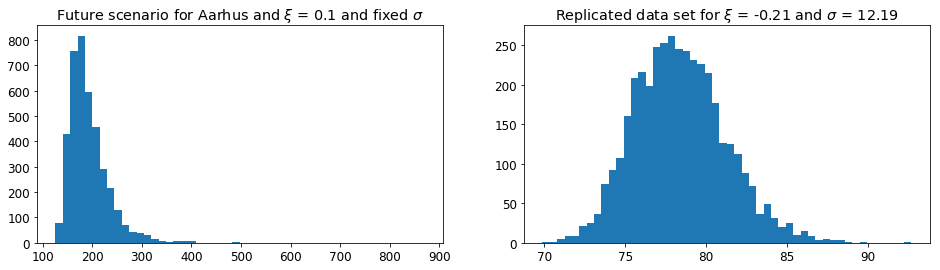

In [30]:
for i,my_city in enumerate(['Aarhus']):
    fig,axes = plt.subplots(ncols = 2, figsize=(16,4))
    ax = axes[0]
    ax.hist(np.max(samples_sep['yrep_fut'][:,dstart[i+1]:dend[i+1]],axis = 1),bins = 50)
    ax.set_title(r'Future scenario for {0} and $\xi$ = 0.1 and fixed $\sigma$'.format(my_city))

    ax = axes[1]
    ax.hist(np.max(samples_sep['yrep'][:,dstart[i+1]:dend[i+1]],axis = 1),bins = 50)
    ax.set_title(r'Replicated data set for $\xi$ = {:.2f} and $\sigma$ = {:.2f}'.format(np.mean(samples_sep['k'][:,i+1]),np.mean(samples_sep['sigma'][:,i+1])))
    plt.show()

Values up to 800 km/h are predicted in that case, which is not reasonable. In our case the predictions were quite satsifying, but the GPD does not seem to be most suited for predicting extreme wind speeds in general for the given reasons.

We have used the psis loo and test statistic analysis to select the final model and have found that the psis loo is a good comparison method based on the k-indices. Yet the relatively bad performance of the pooled model seems to be much influenced by a discrepancy in the data, in this case the unrealisticly high values measured in aarhus. There seems no good reason that this dataset should be much more extreme than e.g. esbjerg and aalborg and it would appear to be a consequence of a different measurement approach. A way of fixing this issue would be to include additional weather stations to smooth out this apparent measurement discrepancy.   

An improvement to the hierarchical model in particular could be the inclusion of location data of the weather stations, which would enable spatial correlation to be included in the hyperparameter distributions. 